In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from lovely_tensors import monkey_patch
monkey_patch()


# Saving 08 MNIST dataset

In [2]:
import torchvision.datasets as tds
import torch

ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
)

ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
)

labels = [0, 8]

train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:-1]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)


In [6]:
ds_train = torch.load("data/08MNIST/train.pth", weights_only=False)
ds_test = torch.load("data/08MNIST/test.pth", weights_only=False)

print(ds_train)

In [10]:
from PIL import Image
from pathlib import Path
base_path = Path("data/08MNIST/original/test")
zero_iteration = 0
eight_iteration = 0
for x, target in ds_test:
    x: Image.Image
    if target == 0:
        zero_iteration += 1
        x.save(base_path / "0" / f"{zero_iteration}.png")
    elif target == 8:
        eight_iteration += 1
        x.save(base_path / "8" / f"{eight_iteration}.png")

In [31]:
# checking
import torchvision.transforms.v2 as v2
transform = v2.Compose([v2.ToImage(),     v2.Lambda(lambda x: x[0:1] if x.shape[0] == 3 else x), v2.ToDtype(torch.float32, scale=True)])
target_transform = lambda x: torch.tensor(x)
ds_test = tds.ImageFolder(base_path, transform, target_transform)
ds_train = tds.ImageFolder("data/08MNIST/original/train", transform, target_transform)

In [67]:
x_example, target_example = next(iter(ds_train))
print(f"{x_example=}, {target_example=}")

x_example=tensor[1, 28, 28] n=784 (3.1Kb) x∈[0., 1.000] μ=0.156 σ=0.329, target_example=tensor i64 0


In [28]:
x_example.deeper

Image[1, 28, 28] n=784 (3.1Kb) x∈[0., 0.996] μ=0.155 σ=0.328
  tensor[28, 28] n=784 x∈[0., 0.996] μ=0.155 σ=0.328

# Creating misleading confounded dataset

## idea 1: another type of dot
The **dot** has a fixed position, fixed size

In [79]:
def get_bottom_right_corner(image):
    # Remove the channel dimension
    tensor_2d = image.squeeze(0)
    # Find the indices where the tensor has non-zero values
    non_zero_indices = torch.nonzero(tensor_2d)
    # Get the maximum x, y indices
    max_x, max_y = non_zero_indices.max(dim=0).values
    return max_x.item(), max_y.item()

def get_bottom_right_corner_fixed(image, offset=1):
    h, w = image.shape[-2:]
    return h - offset, w - offset
    

def write_dot_on_image(image, dot_sizes: torch.Size, padding=1):
    corner_x, corner_y = get_bottom_right_corner_fixed(image)
    binary_mask = torch.zeros_like(image)

    # Calculate the starting position of the dot outside the bounding box
    start_x = min(image.shape[2] - dot_sizes[1], corner_x + 1 + padding)
    start_y = min(image.shape[1] - dot_sizes[0], corner_y + 1 + padding)

    # Calculate the ending position of the dot
    end_x = min(image.shape[2], start_x + dot_sizes[1])
    end_y = min(image.shape[1], start_y + dot_sizes[0])

    # Draw the dot on the image
    image[0, start_y:end_y, start_x:end_x] = 1
    binary_mask[0, start_y:end_y, start_x:end_x] = 1

    return image, binary_mask


In [80]:
def write_fixed_dot_on_image(image, dot_sizes: torch.Size, padding=1):
    image = image.clone()
    bottom_right_y, bottom_right_x = get_bottom_right_corner_fixed(image, offset=padding)
    top_left_x, top_left_y = bottom_right_x - dot_sizes[0], bottom_right_y - dot_sizes[1]
    
    binary_mask = torch.zeros_like(image)
    
    image[0, top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 1
    binary_mask[0, top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 1
    
    return image, binary_mask
    

In [81]:
x_example_dotted, example_mask = write_fixed_dot_on_image(x_example, torch.Size((2, 2)))

In [50]:
import torch
import matplotlib.pyplot as plt

def plot_tensor(tensor):
    """
    Plots a 3D (C, H, W) or (H, W, C) image tensor using matplotlib.
    Handles permutation and detaching from graph.
    """
    if tensor.dim() == 4: # If it's a batch, take the first image
        tensor = tensor[0]

    # Detach from computation graph and move to CPU if on GPU
    img_np = tensor.detach().cpu().numpy()

    # If the channels are first (C, H, W), permute to (H, W, C) for matplotlib
    if img_np.shape[0] == 1 or img_np.shape[0] == 3: # Grayscale or RGB/BGR
        if img_np.shape[0] == 3: # RGB
            img_np = img_np.transpose(1, 2, 0)
        elif img_np.shape[0] == 1: # Grayscale, remove channel dimension
            img_np = img_np.squeeze(0)

    plt.imshow(img_np)
    plt.axis('off')
    plt.show()


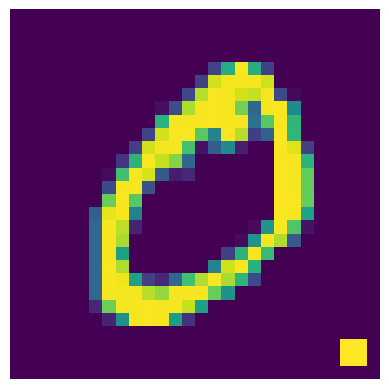

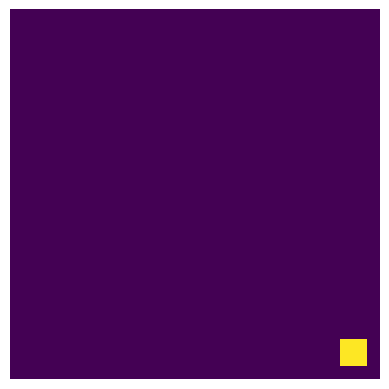

In [82]:
plot_tensor(x_example_dotted)
plot_tensor(example_mask)

In [100]:
confounding_function = lambda image: write_fixed_dot_on_image(image, torch.Size((2, 2)), padding=1)

In [101]:
# Create confounded dataset
to_pil_image = v2.ToPILImage()

def create_confounding_dataset(base_path: Path, dataset, confounding_function=confounding_function):
    zero_iteration = 0
    eight_iteration = 0
    for image, target in dataset:
        if torch.eq(target, torch.tensor((1))):
            # confound 8
            new_image, mask = confounding_function(image)
            eight_iteration += 1
            image_path = base_path / str(dataset.classes[target.item()]) / f"{eight_iteration}.png"
            mask_path = base_path / f"{str(dataset.classes[target.item()])}_mask" / f"{eight_iteration}.png"
        else:
            zero_iteration += 1
            new_image, mask = image, torch.zeros_like(image)
            image_path = base_path / str(dataset.classes[target.item()]) / f"{zero_iteration}.png"
            mask_path = base_path / f"{str(dataset.classes[target.item()])}_mask" / f"{zero_iteration}.png"
        # write down new images
        to_pil_image(new_image).save(image_path)
        to_pil_image(mask).save(mask_path)
    return

In [103]:
create_confounding_dataset(Path("data/08MNIST/confounded_v1/test"), ds_test)

In [91]:
ds_train

Dataset ImageFolder
    Number of datapoints: 11773
    Root location: data/08MNIST/original/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Lambda(<lambda>, types=['object'])
                 ToDtype(scale=True)
           )
Target transform: <function <lambda> at 0x16a8bfb00>

In [104]:
confounded_ds_train = tds.ImageFolder("data/08MNIST/confounded_v1/train", transform, target_transform)
confounded_ds_test = tds.ImageFolder("data/08MNIST/confounded_v1/test", transform, target_transform)

In [106]:
print(f"{len(confounded_ds_train)=}, {len(confounded_ds_test)=}")

len(confounded_ds_train)=23546, len(confounded_ds_test)=3908


In [110]:
from torch.utils.data import DataLoader

False

In [112]:
import numpy as np
confounded_ds_train.classes

['0', '0_mask', '8', '8_mask']

In [119]:
# gather all classes into seperate tensors
def gather_classes(dataset):
    classes = dataset.classes
    class_tensors = {cls: [] for cls in classes}
    
    for x, target in dataset:
        class_tensors[classes[target.item()]].append(x)
    
        
    return {cls: torch.stack(tensor_list) for cls, tensor_list in class_tensors.items()}


In [134]:
bro = gather_classes(confounded_ds_test)

In [135]:
inputs = torch.vstack((bro['0'], bro['8']))
masks = torch.vstack((bro['0_mask'], bro['8_mask']))
labels = torch.cat((torch.tensor(0).repeat(bro['0'].shape[0]), torch.tensor(1).repeat(bro['8'].shape[0])))

In [136]:
bro


{'0': tensor[980, 1, 28, 28] n=768320 (2.9Mb) x∈[0., 1.000] μ=0.172 σ=0.347,
 '0_mask': tensor[980, 1, 28, 28] n=768320 (2.9Mb) all_zeros,
 '8': tensor[974, 1, 28, 28] n=763616 (2.9Mb) x∈[0., 1.000] μ=0.158 σ=0.334,
 '8_mask': tensor[974, 1, 28, 28] n=763616 (2.9Mb) x∈[0., 1.000] μ=0.005 σ=0.071}

In [137]:
from src.xil_research_modification.rrr_dataset import RRRDataset
confounded_ds_test_rrr = RRRDataset(inputs, labels, masks)
torch.save(confounded_ds_test_rrr,"data/08MNIST/confounded_v1/test.pth")